In [1]:
import sys
import os
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer

e:\virual_env\CS909\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
feature_stand_path = "E:/mesa/features/acc_hrv_combine/"
feature_path = "E:/mesa/features/acc_hrv_no_stand/"
overlap_log = "E:/mesa/features/acc_hrv_overlap.txt"
expriment_sample_id_file = "E:/mesa/expriment_samples.txt"

In [3]:
with open(expriment_sample_id_file, 'r') as file:
    lines = file.readlines()

expriment_id_list = [line.strip() for line in lines]
# 输出列表内容
print(expriment_id_list)

['5119', '3974', '1113', '3737', '0468', '1381', '2325', '1431', '0893', '6727', '5162', '0392', '0683', '3293', '5830', '1098', '5369', '1459', '1022', '0144', '1077', '6450', '3793', '6266', '1797', '6052', '2567', '3554', '4527', '2549', '6370', '5740', '5001', '1752', '0904', '3710', '2100', '5031', '3042', '2030', '0914', '5195', '3664', '6337', '0036', '6067', '4880', '5268', '4958', '3703', '1546', '4974', '0074', '1641', '2429', '4309', '4555', '4345', '6557', '4795', '6789', '5127', '5990', '5635', '2212', '5955', '1959', '0427', '5673', '0789', '0110', '6784', '0791', '6616', '2796', '5390', '5932', '4333', '1020', '5503', '1087', '4683', '2451', '5669', '2170', '0910', '3251', '0458', '0594', '0528', '2709', '6722', '0862', '5513', '3332', '4529', '2035', '2217', '2488', '0332']


In [4]:
dl_hrv_feature_names = ["mean_nni", "sdnn", "sdsd", "vlf", "lf", "hf", "lf_hf_ratio", "total_power"]
dl_acc_names = "activity"

In [5]:
test_df = pd.read_csv(os.path.join(feature_stand_path,(expriment_id_list[0]+'_combined.csv')))
test_df = test_df[dl_hrv_feature_names]
print(test_df.shape[0])
test_df.head()

1163


,mean_nni,sdnn,sdsd,vlf,lf,hf,lf_hf_ratio,total_power
0,0.249651,0.216277,0.135700,0.209112,-0.067317,-0.082923,-0.294740,-0.050956
1,0.078485,-0.069824,-0.232090,-0.238372,-0.090769,-0.100113,-0.273266,-0.109704
2,0.129879,-0.198571,-0.131532,-0.250864,-0.109174,-0.094426,-0.465916,-0.120742
3,0.255071,-0.320846,-0.221557,-0.277589,-0.104212,-0.096194,-0.426207,-0.120422
4,0.219076,-0.395855,-0.202124,-0.289961,-0.108247,-0.099200,-0.451693,-0.124999


In [6]:
#test_win = 20
def build_window_feature(df,win_len=20,feature_list=[]):
    fill_values = {}
    df_x = df[feature_list].copy()
    for s in range(1,round(win_len/2)+1):
        for feature in feature_list:
            df_x["%s_shift_%d" %(feature,s)] = df_x[feature].shift(s)
            # columns = df_x.columns.tolist()
            # columns = columns[::-1]  # or data_frame = data_frame.sort_index(ascending=True, axis=0)
            # df_x = df_x[columns]
            fill_values["%s_shift_%d" %(feature,s)] = df_x.loc[s:s+round(win_len/2)+1, feature].mean()


    #test_df.fillna(fill_value)
    for s in range(1,round(win_len/2)+1):
        for feature in feature_list:
            df_x["%s_shift_-%d" %(feature,s)] = df_x[feature].shift(-s)
            fill_values["%s_shift_-%d" %(feature,s)] = df_x.iloc[-(s+round(win_len/2)+1):-s][feature].mean()
            #print(df.loc[-(s+round(win_len/2)+1), feature])

    for column, value in fill_values.items():
        df_x[column].fillna(value, inplace=True)
    #print(fill_values)
    df_x.sort_index()
    return df_x

In [7]:
test_df_window=build_window_feature(test_df,50,dl_hrv_feature_names)
print(test_df_window.isnull().any().any())
test_df_window.tail(10)

e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


False


,mean_nni,sdnn,sdsd,vlf,lf,hf,lf_hf_ratio,total_power,mean_nni_shift_1,sdnn_shift_1,...,lf_hf_ratio_shift_-24,total_power_shift_-24,mean_nni_shift_-25,sdnn_shift_-25,sdsd_shift_-25,vlf_shift_-25,lf_shift_-25,hf_shift_-25,lf_hf_ratio_shift_-25,total_power_shift_-25
1153,-3.770287,0.838663,1.176138,-0.161039,-0.107842,-0.105226,-0.420371,-0.115562,-3.499295,0.007922,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1154,-3.948870,-0.492567,-0.492269,-0.285007,-0.110836,-0.111770,-0.390085,-0.130159,-3.770287,0.838663,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1155,-3.879892,0.109286,0.632999,-0.220223,-0.052316,0.058057,-0.437907,-0.034124,-3.948870,-0.492567,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1156,-3.860773,0.593480,1.528704,-0.216088,-0.043140,0.008021,-0.410341,-0.043566,-3.879892,0.109286,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1157,-0.898263,4.837062,7.497588,0.768435,0.722553,9.987754,-0.470980,3.651640,-3.860773,0.593480,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1158,7.679412,10.315017,14.687730,12.263497,7.978560,0.293827,2.014863,6.236111,-0.898263,4.837062,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1159,0.862850,11.028526,9.432270,11.278128,21.518695,21.006065,-0.352907,21.272180,7.679412,10.315017,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1160,5.978670,-0.417241,-0.709033,-0.291831,-0.111294,-0.111181,-0.471437,-0.130852,0.862850,11.028526,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1161,4.217312,8.273123,5.336504,1.741981,1.753773,6.177321,-0.444150,3.201232,5.978670,-0.417241,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218
1162,4.621609,22.920745,13.940662,19.853532,23.812253,21.230219,-0.340781,23.541943,4.217312,8.273123,...,-0.093118,-0.116593,-3.273804,-0.187981,-0.06827,-0.230982,-0.102759,-0.101701,-0.194055,-0.117218


In [8]:
def pre_features_labels(id_list,path,win_length,feature_names):
    all_hrv_df_list =[]
    label_list =[]
    for overlap_id in id_list:

        all_feature_df = pd.read_csv(os.path.join(path,(overlap_id+'_combined.csv')))

        label = all_feature_df["stages"].to_list()
        label_list = label_list+label

        #hrv_feature_df = all_feature_df[dl_hrv_feature_names]
        
        hrv_feature_df=build_window_feature(all_feature_df,win_length,feature_names)
        #print(type(hrv_feature_df))
        #print(hrv_feature_20_df.shape[1])
        all_hrv_df_list.append(hrv_feature_df)
        
    process_df = pd.concat(all_hrv_df_list)
    return process_df,label_list

## HRV features

In [9]:
all_hrv_20_df, PSG_label_list = pre_features_labels(expriment_id_list,feature_stand_path,20,dl_hrv_feature_names)
print(all_hrv_20_df.shape[0],all_hrv_20_df.shape[1])

e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


112296 168


In [10]:
all_hrv_50_df, _ = pre_features_labels(expriment_id_list,feature_stand_path,50,dl_hrv_feature_names)
print(all_hrv_50_df.shape[0],all_hrv_50_df.shape[1])

e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


112296 408


In [13]:
all_hrv_100_df, _ = pre_features_labels(expriment_id_list,feature_stand_path,100,dl_hrv_feature_names)
print(all_hrv_100_df.shape[0],all_hrv_100_df.shape[1])

e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


112296 808


In [14]:
all_hrv_20_df.head()

,mean_nni,sdnn,sdsd,vlf,lf,hf,lf_hf_ratio,total_power,mean_nni_shift_1,sdnn_shift_1,...,lf_hf_ratio_shift_-9,total_power_shift_-9,mean_nni_shift_-10,sdnn_shift_-10,sdsd_shift_-10,vlf_shift_-10,lf_shift_-10,hf_shift_-10,lf_hf_ratio_shift_-10,total_power_shift_-10
0,0.249651,0.216277,0.135700,0.209112,-0.067317,-0.082923,-0.294740,-0.050956,0.204389,-0.278371,...,-0.405589,-0.118952,0.157553,-0.285499,-0.185979,-0.243232,-0.101473,-0.093315,-0.416596,-0.114825
1,0.078485,-0.069824,-0.232090,-0.238372,-0.090769,-0.100113,-0.273266,-0.109704,0.249651,0.216277,...,-0.416596,-0.114825,0.154917,-0.351923,-0.220388,-0.275420,-0.109285,-0.096313,-0.464985,-0.123511
2,0.129879,-0.198571,-0.131532,-0.250864,-0.109174,-0.094426,-0.465916,-0.120742,0.078485,-0.069824,...,-0.464985,-0.123511,0.174346,-0.282680,-0.224323,-0.195731,-0.101061,-0.100097,-0.377192,-0.112607
3,0.255071,-0.320846,-0.221557,-0.277589,-0.104212,-0.096194,-0.426207,-0.120422,0.129879,-0.198571,...,-0.377192,-0.112607,0.114065,-0.306882,-0.153081,-0.257479,-0.099512,-0.093295,-0.403893,-0.114790
4,0.219076,-0.395855,-0.202124,-0.289961,-0.108247,-0.099200,-0.451693,-0.124999,0.255071,-0.320846,...,-0.403893,-0.114790,0.147011,-0.330330,-0.209416,-0.287039,-0.093901,-0.097913,-0.331384,-0.115190


In [15]:
has_null_values = all_hrv_100_df.isnull().any().any()
print(has_null_values)

False


In [16]:
def draw_cof_martix(y_PSG_stages_label,y_PSG_stages_pred):   

    conf_martix = confusion_matrix(y_PSG_stages_label,y_PSG_stages_pred)

    # 打印混淆矩阵
    print("hrv feature 3 classification Confusion Matrix:")
    print(conf_martix)

    # 计算每个类别的总数
    class_totals = np.sum(conf_martix, axis=1)
    class_names = np.unique(y_PSG_stages_label)

    # 计算每个单元格的百分比
    cell_percentages = conf_martix / class_totals[:, np.newaxis]
    cell_numbers = conf_martix

    # 绘制混淆矩阵热图
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cell_percentages,annot=False, cmap='Blues', fmt='.2%', xticklabels= class_names, yticklabels= class_names)
    

    for i in range(len( class_names)):
        for j in range(len(class_names)):
            ax.text(j + 0.5, i + 0.5, f'{cell_percentages[i, j]:.2%}\n{cell_numbers[i, j]}',
                ha='center', va='center', color='black')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.show()

## Prepare Labels

In [17]:
class_2_labels = []#0=weak,1=sleep
class_3_labels = []#0=weak,1/2/3=NREM=1,4=REM=2
class_4_lables = []#0=weak,1/2=light sleep=1, 3=deep sleep=2,4=REM=3
for labels in PSG_label_list:
    if labels == 0:
        class_2_labels.append(0)
        class_3_labels.append(0)
        class_4_lables.append(0)
    elif labels == 1:
        class_2_labels.append(1)
        class_3_labels.append(1)
        class_4_lables.append(1)
    elif labels == 2:
        class_2_labels.append(1)
        class_3_labels.append(1)
        class_4_lables.append(1)
    elif labels == 3:
        class_2_labels.append(1)
        class_3_labels.append(1)
        class_4_lables.append(2)
    elif labels == 4:
        class_2_labels.append(1)
        class_3_labels.append(2)
        class_4_lables.append(3)
class_5_labels = PSG_label_list

print(set(class_2_labels))
print(set(class_3_labels))
print(set(class_4_lables))

{0, 1}
{0, 1, 2}
{0, 1, 2, 3}


In [18]:
hrv_20_X_train_val, hrv_20_X_test, hrv_20_Y_train_val, hrv_20_Y_test = train_test_split(all_hrv_20_df, class_3_labels, test_size=0.2, random_state=42)
hrv_20_X_train, hrv_20_X_val,hrv_20_Y_train,hrv_20_Y_val = train_test_split(hrv_20_X_train_val, hrv_20_Y_train_val, test_size=0.2, random_state=42)
#print(type(hrv_20_X_train))

In [19]:
hrv_50_X_train_val, hrv_50_X_test, hrv_50_Y_train_val, hrv_50_Y_test = train_test_split(all_hrv_50_df, class_3_labels, test_size=0.2, random_state=42)
hrv_50_X_train, hrv_50_X_val,hrv_50_Y_train,hrv_50_Y_val = train_test_split(hrv_50_X_train_val, hrv_50_Y_train_val, test_size=0.2, random_state=42)

In [20]:
hrv_100_X_train_val, hrv_100_X_test, hrv_100_Y_train_val, hrv_100_Y_test = train_test_split(all_hrv_100_df, class_3_labels, test_size=0.2, random_state=42)
hrv_100_X_train, hrv_100_X_val,hrv_100_Y_train,hrv_100_Y_val = train_test_split(hrv_100_X_train_val, hrv_100_Y_train_val, test_size=0.2, random_state=42)
#print(type(hrv_20_X_train))

In [21]:
def reshape_feature(df,feature_nums,sequnence_len):
    samples_nums = df.shape[0]
    data_array = df.values

    # 初始化一个用于存储新形状的数组
    feature_array = np.zeros((samples_nums, feature_nums, sequnence_len))

# 将每个样本重新形状并存储到新数组中
    for i in range(samples_nums):
        sample = data_array[i]  # 获取一个样本的数据
        reshaped_sample = sample.reshape(feature_nums, sequnence_len)  # 重新形状为 8x101
        feature_array[i] = reshaped_sample
    return feature_array

In [22]:
def pre_data_loader(feature,label,batch_size,Reshape = False,feature_nums=8,Seq_len=21):
    label_np = np.expand_dims(label, -1).astype(np.float32)
    #print(label_np)
    enc = OneHotEncoder(handle_unknown='ignore')#如果 handle_unknown='ignore'，则在进行编码时，如果遇到未知的分类变量取值，会忽略该取值并将对应的编码向量全部置为 0。
    labels = enc.fit_transform(label_np).toarray()
    print(labels)

    if Reshape:
        feature_reshaped = reshape_feature(feature,feature_nums,Seq_len)
        features_tensor= torch.tensor(feature_reshaped, dtype=torch.float32)
    else:
        features_tensor= torch.tensor(feature.values, dtype=torch.float32)
        features_tensor = features_tensor.unsqueeze(1)

    label_tensor = torch.tensor(labels, dtype=torch.long)
    
    dataset = TensorDataset(features_tensor, label_tensor)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader


In [23]:
hrv_20_train_dataloader = pre_data_loader(hrv_20_X_train, hrv_20_Y_train,32)
hrv_20_val_dataloader = pre_data_loader(hrv_20_X_val,hrv_20_Y_val,32)
hrv_20_test_dataloader = pre_data_loader(hrv_20_X_test,hrv_20_Y_test,32)
print(hrv_20_train_dataloader,hrv_20_val_dataloader,hrv_20_test_dataloader)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x00000224D7D203C8> <torch.utils.data.dataloader.DataLoader object at 0x00000224D7D20F08> <torch.utils.data.dataloader.DataLoader object at 0x00000224D7D20808>


In [24]:
hrv_100_train_dataloader = pre_data_loader(hrv_100_X_train, hrv_100_Y_train,32)
hrv_100_val_dataloader = pre_data_loader(hrv_100_X_val,hrv_100_Y_val,32)
hrv_100_test_dataloader = pre_data_loader(hrv_100_X_test,hrv_100_Y_test,32)
print(hrv_100_train_dataloader,hrv_100_val_dataloader,hrv_100_test_dataloader)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x00000224AB7B62C8> <torch.utils.data.dataloader.DataLoader object at 0x00000224D7154948> <torch.utils.data.dataloader.DataLoader object at 0x00000224D756BDC8>


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [27]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [28]:
def eval_model(model,moel_path,test_data):   
    model.load_state_dict(torch.load(moel_path))
    model.to('cpu')
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_data:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    #print(all_predictions,all_targets)

    # all_predictions = np.argmax(np.array(all_predictions), axis=1)
    all_targets = np.argmax(np.array(all_targets), axis=1)
            
    accuracy = accuracy_score(all_targets, all_predictions)
    print('Accuracy: {:.2%}'.format(accuracy))
    precision = precision_score(all_targets, all_predictions, average='macro')
    print(f'Precision:: {precision:.4f}')
    recall = recall_score(all_targets, all_predictions, average='macro')
    print(f'Recall: {recall:.4f}')
    f1 = f1_score(all_targets, all_predictions, average='macro')  # 你可以选择 'micro'、'macro' 或其他适合的值
    print(f'F1 Score: {f1:.4f}')
    draw_cof_martix(all_targets,all_predictions)

In [29]:
def train_save(num_epochs,model,model_path,criterion, optimizer,train_data,val_data):   
    #num_epochs = 20
    best_loss = float("inf")
    #CNN_100_model_path = './models/DL_CNN_100_best_model.pth'
    patience = 5  # 连续多少个周期验证集损失不下降就停止
    counter = 0
    for epoch in range(num_epochs):
        train_loss = train(model, train_data, criterion, optimizer)
        val_loss = validate(model,val_data, criterion)
        if val_loss<best_loss:
            #torch.save(CNN_model.state_dict(), CNN_100_model_path)
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            torch.save(model.state_dict(), model_path)
            print("Early stopping triggered. Training stopped.")
            break
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=7)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        self.fc1 = nn.Linear(50944, 256)
        self.fc2 =  nn.Linear(256, 3) # 全连接层的输入大小为 16 * 162

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool1d(x, kernel_size=2)  # 最大池化
        x = x.view(x.size(0), -1)  # 展平特征向量，以便全连接层处理
        #print(x.shape)
        x = self.fc1(x)
        x= torch.relu(x)
        x = self.fc2(x)
        return x


In [29]:
# 定义损失函数和优化器
CNN_model = SimpleCNN().to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(CNN_model.parameters(), lr=0.0001, alpha=0.9)

Epoch [1/40] - Train Loss: 0.4311, Val Loss: 0.3934
Epoch [2/40] - Train Loss: 0.3618, Val Loss: 0.3597
Epoch [3/40] - Train Loss: 0.3144, Val Loss: 0.3416
Epoch [4/40] - Train Loss: 0.2742, Val Loss: 0.3327
Epoch [5/40] - Train Loss: 0.2388, Val Loss: 0.3421
Epoch [6/40] - Train Loss: 0.2083, Val Loss: 0.3500
Epoch [7/40] - Train Loss: 0.1823, Val Loss: 0.3753
Epoch [8/40] - Train Loss: 0.1607, Val Loss: 0.3862
Early stopping triggered. Training stopped.
Accuracy: 67.68%
Precision:: 0.6659
Recall: 0.7331
F1 Score: 0.6442
hrv feature 3 classification Confusion Matrix:
[[5673  914 1439]
 [1093 7375 3512]
 [ 107  195 2152]]


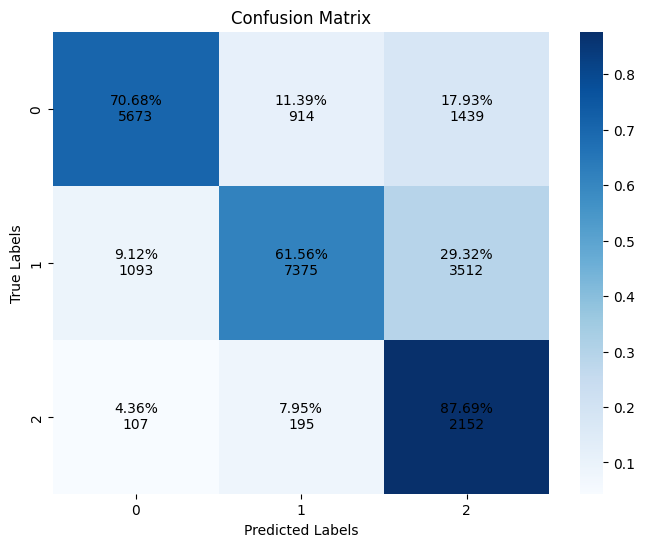

In [30]:
CNN_100_model_path = './models/DL_CNN_100_best_model.pth'
train_save(40,CNN_model,CNN_100_model_path,criterion,optimizer,hrv_100_train_dataloader,hrv_100_val_dataloader)
eval_model(CNN_model,CNN_100_model_path,hrv_100_test_dataloader)

## LSTM

In [30]:
hrv_100_reshape_train_dataloader = pre_data_loader(hrv_100_X_train, hrv_100_Y_train,32,Reshape=True,feature_nums=8,Seq_len=101)
hrv_100_reshape_val_dataloader = pre_data_loader(hrv_100_X_val,hrv_100_Y_val,32,Reshape=True,feature_nums=8,Seq_len=101)
hrv_100_reshape_test_dataloader = pre_data_loader(hrv_100_X_test,hrv_100_Y_test,32,Reshape=True,feature_nums=8,Seq_len=101)
print(hrv_100_reshape_train_dataloader,hrv_100_reshape_val_dataloader,hrv_100_reshape_test_dataloader)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x00000224CD105888> <torch.utils.data.dataloader.DataLoader object at 0x00000224D756B408> <torch.utils.data.dataloader.DataLoader object at 0x00000224D756BEC8>


In [31]:
hrv_50_reshape_train_dataloader = pre_data_loader(hrv_50_X_train, hrv_50_Y_train,32,Reshape=True,feature_nums=8,Seq_len=51)
hrv_50_reshape_val_dataloader = pre_data_loader(hrv_50_X_val,hrv_50_Y_val,32,Reshape=True,feature_nums=8,Seq_len=51)
hrv_50_reshape_test_dataloader = pre_data_loader(hrv_50_X_test,hrv_50_Y_test,32,Reshape=True,feature_nums=8,Seq_len=51)
print(hrv_50_reshape_train_dataloader,hrv_50_reshape_val_dataloader,hrv_50_reshape_test_dataloader)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x00000224D7145C48> <torch.utils.data.dataloader.DataLoader object at 0x00000224D7D204C8> <torch.utils.data.dataloader.DataLoader object at 0x00000224D7D20888>


In [32]:
hrv_20_reshape_train_dataloader = pre_data_loader(hrv_20_X_train, hrv_20_Y_train,32,Reshape=True,feature_nums=8,Seq_len=21)
hrv_20_reshape_val_dataloader = pre_data_loader(hrv_20_X_val,hrv_20_Y_val,32,Reshape=True,feature_nums=8,Seq_len=21)
hrv_20_reshape_test_dataloader = pre_data_loader(hrv_20_X_test,hrv_20_Y_test,32,Reshape=True,feature_nums=8,Seq_len=21)
print(hrv_20_reshape_train_dataloader,hrv_20_reshape_val_dataloader,hrv_20_reshape_test_dataloader)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x000002248B359188> <torch.utils.data.dataloader.DataLoader object at 0x00000224D7A13748> <torch.utils.data.dataloader.DataLoader object at 0x00000224D7A13CC8>


In [33]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        
        # LSTM 层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 全连接层用于分类
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # LSTM 前向传播
        out, _ = self.lstm(x)
        
        # 取最后一个时间步的输出，作为全连接层的输入
        out = out[:, -1, :]
        
        # 使用全连接层进行分类
        out = self.fc(out)
        return out

In [34]:
for batch in hrv_100_reshape_test_dataloader:
    # 打印该批次数据中第一个张量的形状
    first_tensor = batch[0]  # 获取第一个张量
    print(first_tensor.shape)
    # 这将输出 (seq_length, input_size)
    break  # 只查看第一个批次

torch.Size([32, 8, 101])


In [35]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM 隐藏单元数量
num_layers = 2 # LSTM 层数
num_classes = 3  # 分类类别数量

# 创建 LSTM 模型
LSTM_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_model.parameters(), lr=0.0001, alpha=0.9)
# 打印模型结构
print(LSTM_model)

LSTMClassifier(
  (lstm): LSTM(101, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)


Epoch [1/40] - Train Loss: 0.4815, Val Loss: 0.4613
Epoch [2/40] - Train Loss: 0.4462, Val Loss: 0.4424
Epoch [3/40] - Train Loss: 0.4259, Val Loss: 0.4274
Epoch [4/40] - Train Loss: 0.4059, Val Loss: 0.4158
Epoch [5/40] - Train Loss: 0.3825, Val Loss: 0.4043
Epoch [6/40] - Train Loss: 0.3551, Val Loss: 0.3929
Epoch [7/40] - Train Loss: 0.3224, Val Loss: 0.3802
Epoch [8/40] - Train Loss: 0.2837, Val Loss: 0.3663
Epoch [9/40] - Train Loss: 0.2405, Val Loss: 0.3594
Epoch [10/40] - Train Loss: 0.1960, Val Loss: 0.3555
Epoch [11/40] - Train Loss: 0.1537, Val Loss: 0.3516
Epoch [12/40] - Train Loss: 0.1156, Val Loss: 0.3601
Epoch [13/40] - Train Loss: 0.0857, Val Loss: 0.3954
Epoch [14/40] - Train Loss: 0.0630, Val Loss: 0.4183
Epoch [15/40] - Train Loss: 0.0475, Val Loss: 0.4300
Early stopping triggered. Training stopped.
Accuracy: 84.18%
Precision:: 0.8224
Recall: 0.7824
F1 Score: 0.7993
hrv feature 3 classification Confusion Matrix:
[[ 6740  1122   164]
 [ 1060 10648   272]
 [  298   638

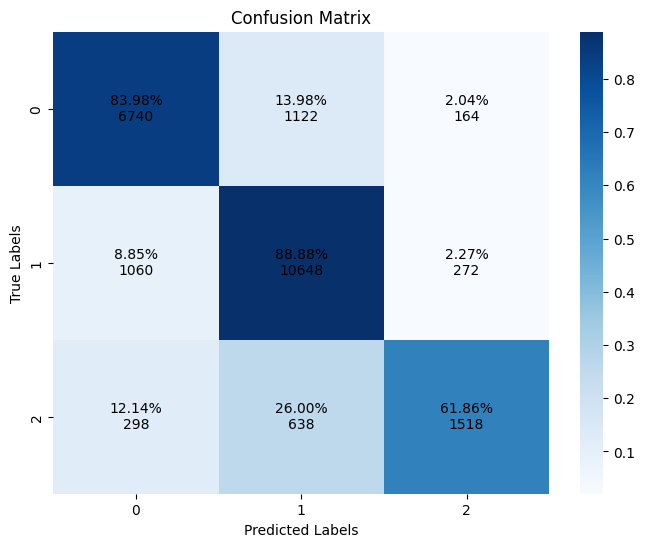

In [36]:
LSTM_100_model_path = './models/DL_LSTM_100_best_model.pth'
train_save(40,LSTM_model,LSTM_100_model_path,criterion,optimizer,hrv_100_reshape_train_dataloader,hrv_100_reshape_val_dataloader)
eval_model(LSTM_model, LSTM_100_model_path,hrv_100_reshape_test_dataloader)

## LSTM-Attention

In [37]:


class SoftAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SoftAttention, self).__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, query, key, value):
        scores = torch.matmul(self.query(query), self.key(key).transpose(-2, -1)) / (key.shape[-1] ** 0.5)
        weights = torch.nn.functional.softmax(scores, dim=-1)
        soft_attention = torch.matmul(weights, self.value(value))
        return soft_attention

In [38]:
class TransformerLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, num_heads):
        super(TransformerLSTMClassifier, self).__init__()
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # 自注意力机制（Transformer的多头注意力）
        #self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)
        self.attention = SoftAttention(hidden_dim)
        
        # 全连接层用于分类
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # LSTM前向传播
        out, _ = self.lstm(x)
        
        # 注意力机制前向传播
        #out, _ = self.attention(out.permute(1, 0, 2), out.permute(1, 0, 2), out.permute(1, 0, 2))
        #out = out.permute(1, 0, 2)
        attention_out = self.attention(out, out, out)
        
        # 取最后一个时间步的输出，作为全连接层的输入
        #out = out[:, -1, :]
        out = attention_out[:, -1, :]
        
        # 使用全连接层进行分类
        out = self.fc(out)
        return out

In [39]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM隐藏单元数量
num_layers = 2  # LSTM层数
num_classes = 3  # 分类类别数量
num_heads = 8  # 自注意力机制中的注意力头数

# 创建模型
LSTM_Attentionnn_model = TransformerLSTMClassifier(input_size, hidden_size, num_layers, num_classes, num_heads).to(device)
LSTM_Attentionnn_model.to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_Attentionnn_model.parameters(), lr=0.0002, alpha=0.9)

In [40]:
LSTM_Attention_100_model_path = './models/DL_LSTM_Attention_100_best_model.pth'
train_save(40,LSTM_Attentionnn_model,LSTM_Attention_100_model_path,criterion,optimizer,hrv_100_reshape_train_dataloader,hrv_100_reshape_val_dataloader)

Epoch [1/40] - Train Loss: 0.4794, Val Loss: 0.4568
Epoch [2/40] - Train Loss: 0.4401, Val Loss: 0.4283
Epoch [3/40] - Train Loss: 0.4084, Val Loss: 0.4105
Epoch [4/40] - Train Loss: 0.3723, Val Loss: 0.3935
Epoch [5/40] - Train Loss: 0.3286, Val Loss: 0.3663
Epoch [6/40] - Train Loss: 0.2765, Val Loss: 0.3523
Epoch [7/40] - Train Loss: 0.2266, Val Loss: 0.3237
Epoch [8/40] - Train Loss: 0.1829, Val Loss: 0.3291
Epoch [9/40] - Train Loss: 0.1454, Val Loss: 0.3315
Epoch [10/40] - Train Loss: 0.1146, Val Loss: 0.3670
Epoch [11/40] - Train Loss: 0.0956, Val Loss: 0.3545
Early stopping triggered. Training stopped.


Accuracy: 84.99%
Precision:: 0.8233
Recall: 0.8026
F1 Score: 0.8122
hrv feature 3 classification Confusion Matrix:
[[ 6648  1189   189]
 [  851 10771   358]
 [  334   450  1670]]


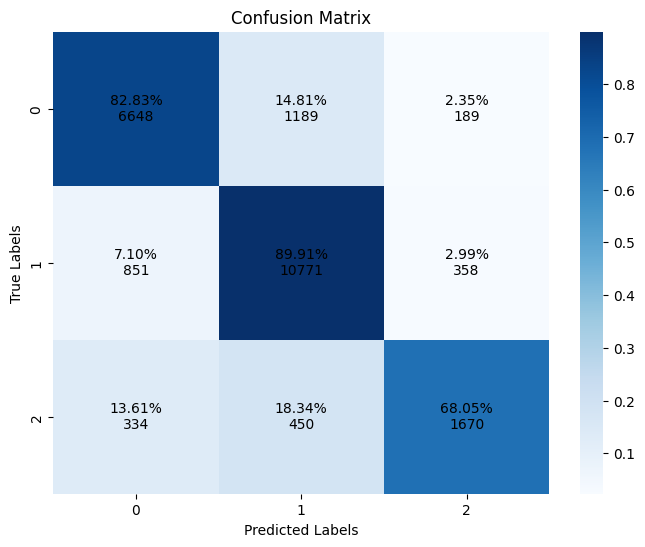

In [41]:
eval_model(LSTM_Attentionnn_model, LSTM_Attention_100_model_path , hrv_100_reshape_test_dataloader)

## 9 Feature

### Add feature: Mean HR (mean_hr)

In [101]:
add_dl_hrv_feature = ["mean_hr","pnni_50","rmssd"]
dl_hrv_feature_names_add1 = dl_hrv_feature_names[:]
dl_hrv_feature_names_add1= dl_hrv_feature_names_add1+add_dl_hrv_feature
print(dl_hrv_feature_names_add1)

['mean_nni', 'sdnn', 'sdsd', 'vlf', 'lf', 'hf', 'lf_hf_ratio', 'total_power', 'mean_hr', 'pnni_50', 'rmssd']


In [102]:
all_hrv_meanhr_100_df, _ = pre_features_labels(expriment_id_list,feature_stand_path,100,dl_hrv_feature_names_add1)


e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


In [103]:
hrv_9meanhr_100_X_train_val, hrv_9meanhr_100_X_test, hrv_9meanhr_100_Y_train_val, hrv_9meanhr_100_Y_test = train_test_split(all_hrv_meanhr_100_df, class_3_labels, test_size=0.2, random_state=42)
hrv_9meanhr_100_X_train, hrv_9meanhr_100_X_val,hrv_9meanhr_100_Y_train,hrv_9meanhr_100_Y_val = train_test_split(hrv_9meanhr_100_X_train_val, hrv_9meanhr_100_Y_train_val, test_size=0.2, random_state=42)

In [104]:
hrv_9meanhr_100_train_dataloader = pre_data_loader(hrv_9meanhr_100_X_train, hrv_9meanhr_100_Y_train,32)
hrv_9meanhr_100_val_dataloader = pre_data_loader(hrv_9meanhr_100_X_val,hrv_9meanhr_100_Y_val,32)
hrv_9meanhr_100_test_dataloader = pre_data_loader(hrv_9meanhr_100_X_test,hrv_9meanhr_100_Y_test,32)
print(hrv_9meanhr_100_train_dataloader,hrv_9meanhr_100_val_dataloader,hrv_9meanhr_100_test_dataloader)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x000002462C401F88> <torch.utils.data.dataloader.DataLoader object at 0x000002462C401648> <torch.utils.data.dataloader.DataLoader object at 0x000002462C401148>


#### CNN

In [109]:
class CNN_9_feature(nn.Module):
    def __init__(self):
        super(CNN_9_feature, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=7)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        self.fc1 = nn.Linear(70272, 256)
        self.fc2 =  nn.Linear(256, 3) # 全连接层的输入大小为 16 * 162

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool1d(x, kernel_size=2)  # 最大池化
        x = x.view(x.size(0), -1)  # 展平特征向量，以便全连接层处理
        #print(x.shape)
        x = self.fc1(x)
        x= torch.relu(x)
        x = self.fc2(x)
        return x


In [110]:
CNN_9_feature_model = CNN_9_feature().to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(CNN_9_feature_model.parameters(), lr=0.0001, alpha=0.9)

Epoch [1/40] - Train Loss: 0.4253, Val Loss: 0.3858
Epoch [2/40] - Train Loss: 0.3495, Val Loss: 0.3527
Epoch [3/40] - Train Loss: 0.2988, Val Loss: 0.3351
Epoch [4/40] - Train Loss: 0.2564, Val Loss: 0.3359
Epoch [5/40] - Train Loss: 0.2196, Val Loss: 0.3443
Epoch [6/40] - Train Loss: 0.1879, Val Loss: 0.3612
Epoch [7/40] - Train Loss: 0.1615, Val Loss: 0.3999
Early stopping triggered. Training stopped.
Accuracy: 73.85%
Precision:: 0.6911
Recall: 0.7629
F1 Score: 0.6953
hrv feature 3 classification Confusion Matrix:
[[6235  783 1008]
 [1231 8352 2397]
 [ 143  312 1999]]


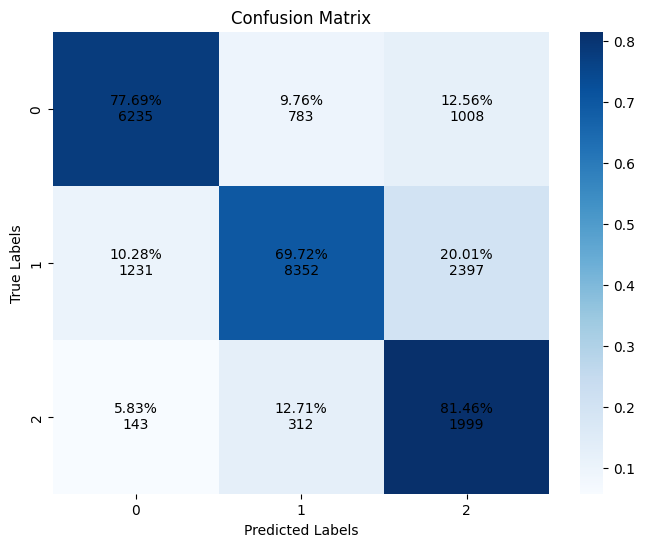

In [111]:
CNN_100_meanhr_path = './models/DL_CNN_11feature_meanhr_pnni50_rmssd.pth'
train_save(40,CNN_9_feature_model,CNN_100_meanhr_path,criterion,optimizer,hrv_9meanhr_100_train_dataloader,hrv_9meanhr_100_val_dataloader)
eval_model(CNN_9_feature_model, CNN_100_meanhr_path , hrv_9meanhr_100_test_dataloader)

#### LSTM

In [112]:
hrv_9meanhr_100_reshape_train_dataloader = pre_data_loader(hrv_9meanhr_100_X_train, hrv_9meanhr_100_Y_train,64,Reshape=True,feature_nums=11,Seq_len=101)
hrv_9meanhr_100_reshape_val_dataloader = pre_data_loader(hrv_9meanhr_100_X_val,hrv_9meanhr_100_Y_val,64,Reshape=True,feature_nums=11,Seq_len=101)
hrv_9meanhr_100_reshape_test_dataloader = pre_data_loader(hrv_9meanhr_100_X_test,hrv_9meanhr_100_Y_test,64,Reshape=True,feature_nums=11,Seq_len=101)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [113]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM 隐藏单元数量
num_layers = 2 # LSTM 层数
num_classes = 3  # 分类类别数量

# 创建 LSTM 模型
LSTM_model_meanhr = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_model_meanhr.parameters(), lr=0.0001, alpha=0.9)
# 打印模型结构
print(LSTM_model)

LSTMClassifier(
  (lstm): LSTM(101, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)


Epoch [1/40] - Train Loss: 0.4846, Val Loss: 0.4616
Epoch [2/40] - Train Loss: 0.4495, Val Loss: 0.4461
Epoch [3/40] - Train Loss: 0.4305, Val Loss: 0.4324
Epoch [4/40] - Train Loss: 0.4134, Val Loss: 0.4226
Epoch [5/40] - Train Loss: 0.3965, Val Loss: 0.4097
Epoch [6/40] - Train Loss: 0.3764, Val Loss: 0.3974
Epoch [7/40] - Train Loss: 0.3515, Val Loss: 0.3856
Epoch [8/40] - Train Loss: 0.3211, Val Loss: 0.3714
Epoch [9/40] - Train Loss: 0.2861, Val Loss: 0.3564
Epoch [10/40] - Train Loss: 0.2474, Val Loss: 0.3422
Epoch [11/40] - Train Loss: 0.2070, Val Loss: 0.3372
Epoch [12/40] - Train Loss: 0.1681, Val Loss: 0.3453
Epoch [13/40] - Train Loss: 0.1326, Val Loss: 0.3460
Epoch [14/40] - Train Loss: 0.1030, Val Loss: 0.3500
Epoch [15/40] - Train Loss: 0.0802, Val Loss: 0.3653
Early stopping triggered. Training stopped.
Accuracy: 83.98%
Precision:: 0.8226
Recall: 0.7701
F1 Score: 0.7915
hrv feature 3 classification Confusion Matrix:
[[ 6568  1298   160]
 [  862 10855   263]
 [  259   757

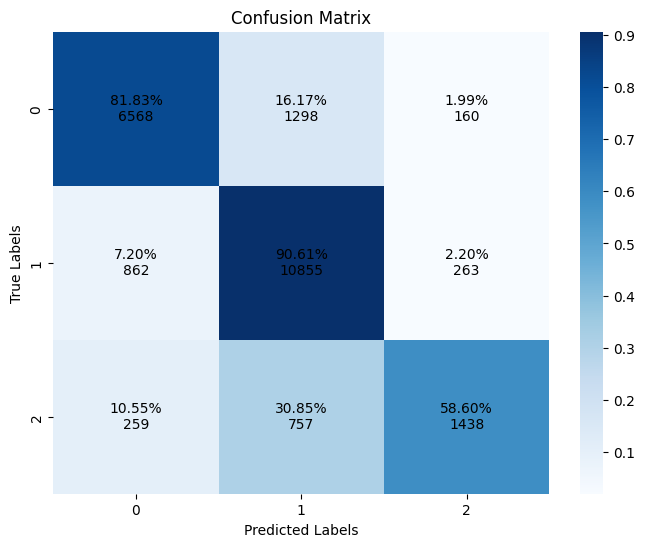

In [114]:
LSTM_meanhr_100_path = './models/DL_LSTM_11feature_model.pth'
train_save(40,LSTM_model_meanhr,LSTM_meanhr_100_path,criterion,optimizer,hrv_9meanhr_100_reshape_train_dataloader,hrv_9meanhr_100_reshape_val_dataloader)
eval_model(LSTM_model_meanhr, LSTM_meanhr_100_path , hrv_9meanhr_100_reshape_test_dataloader)

#### LSTM-Attention

In [116]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM隐藏单元数量
num_layers = 2  # LSTM层数
num_classes = 3  # 分类类别数量
num_heads = 8  # 自注意力机制中的注意力头数

# 创建模型
LSTM_Attentionnn_9_model = TransformerLSTMClassifier(input_size, hidden_size, num_layers, num_classes, num_heads).to(device)
LSTM_Attentionnn_9_model.to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_Attentionnn_9_model.parameters(), lr=0.0002, alpha=0.9)

Epoch [1/40] - Train Loss: 0.4808, Val Loss: 0.4562
Epoch [2/40] - Train Loss: 0.4430, Val Loss: 0.4331
Epoch [3/40] - Train Loss: 0.4142, Val Loss: 0.4153
Epoch [4/40] - Train Loss: 0.3809, Val Loss: 0.3941
Epoch [5/40] - Train Loss: 0.3365, Val Loss: 0.3644
Epoch [6/40] - Train Loss: 0.2817, Val Loss: 0.3398
Epoch [7/40] - Train Loss: 0.2230, Val Loss: 0.3249
Epoch [8/40] - Train Loss: 0.1692, Val Loss: 0.3163
Epoch [9/40] - Train Loss: 0.1258, Val Loss: 0.3337
Epoch [10/40] - Train Loss: 0.0959, Val Loss: 0.3844
Epoch [11/40] - Train Loss: 0.0750, Val Loss: 0.4094
Epoch [12/40] - Train Loss: 0.0618, Val Loss: 0.3961
Early stopping triggered. Training stopped.
Accuracy: 86.41%
Precision:: 0.8431
Recall: 0.8209
F1 Score: 0.8312
hrv feature 3 classification Confusion Matrix:
[[ 6761  1089   176]
 [  767 10904   309]
 [  197   514  1743]]


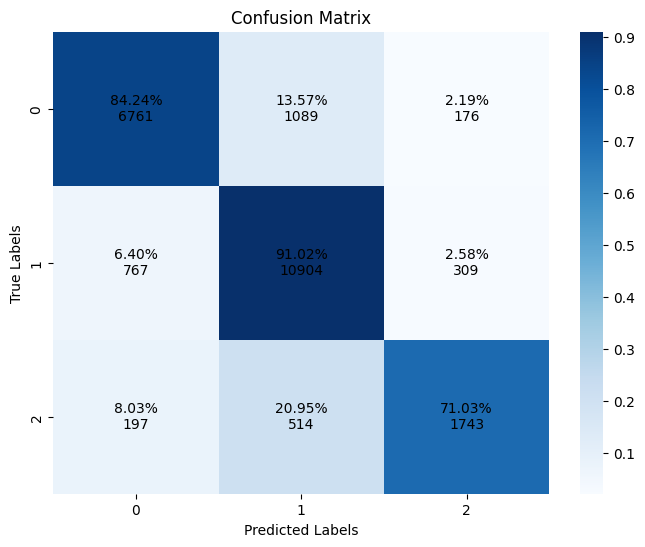

In [117]:
LSTM_Attention_meanhr_model_path = './models/DL_LSTM_Attention_11feature_model.pth'
train_save(40,LSTM_Attentionnn_9_model,LSTM_Attention_meanhr_model_path,criterion,optimizer,hrv_9meanhr_100_reshape_train_dataloader,hrv_9meanhr_100_reshape_val_dataloader)
eval_model(LSTM_Attentionnn_9_model, LSTM_Attention_meanhr_model_path , hrv_9meanhr_100_reshape_test_dataloader)

### Add feature: pNN50 (pnni_50)

## 10 features

### Mean HR: mean_hr, pNN50: pnni_50

In [73]:
add2_dl_hrv_feature = ["mean_hr","pnni_50"]
dl_hrv_feature_names_add2 = dl_hrv_feature_names[:]
dl_hrv_feature_names_add2 = dl_hrv_feature_names_add2 + add2_dl_hrv_feature
print(dl_hrv_feature_names_add2)

['mean_nni', 'sdnn', 'sdsd', 'vlf', 'lf', 'hf', 'lf_hf_ratio', 'total_power', 'mean_hr', 'pnni_50']


In [74]:
all_hrv_10_100_df, _ = pre_features_labels(expriment_id_list,feature_stand_path,100,dl_hrv_feature_names_add2)

e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


In [85]:
hrv_10_100_X_train_val, hrv_10_100_X_test, hrv_10_100_Y_train_val, hrv_10_100_Y_test = train_test_split(all_hrv_10_100_df, class_3_labels, test_size=0.2, random_state=42)
hrv_10_100_X_train, hrv_10_100_X_val,hrv_10_100_Y_train,hrv_10_100_Y_val = train_test_split(hrv_10_100_X_train_val, hrv_10_100_Y_train_val, test_size=0.2, random_state=42)

In [87]:
hrv_10_100_train_dataloader = pre_data_loader(hrv_10_100_X_train, hrv_10_100_Y_train,32)
hrv_10_100_val_dataloader = pre_data_loader(hrv_10_100_X_val,hrv_10_100_Y_val,32)
hrv_10_100_test_dataloader = pre_data_loader(hrv_10_100_X_test,hrv_10_100_Y_test,32)
print(hrv_10_100_train_dataloader,hrv_10_100_val_dataloader,hrv_10_100_test_dataloader)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x0000026C12895A88> <torch.utils.data.dataloader.DataLoader object at 0x0000026C12895208> <torch.utils.data.dataloader.DataLoader object at 0x0000026C12895908>


#### CNN

In [91]:
class CNN_10feature(nn.Module):
    def __init__(self):
        super(CNN_10feature, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=7)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        self.fc1 = nn.Linear(63872, 256)
        self.fc2 =  nn.Linear(256, 3) # 全连接层的输入大小为 16 * 162

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool1d(x, kernel_size=2)  # 最大池化
        x = x.view(x.size(0), -1)  # 展平特征向量，以便全连接层处理
        #print(x.shape)
        x = self.fc1(x)
        x= torch.relu(x)
        x = self.fc2(x)
        return x

In [92]:
CNN_10feature_model = CNN_10feature().to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(CNN_10feature_model.parameters(), lr=0.0001, alpha=0.9)

In [93]:
CNN_100_10_path = './models/DL_CNN_100_meanhr_pnni50_model.pth'
train_save(40,CNN_10feature_model,CNN_100_10_path,hrv_10_100_train_dataloader,hrv_10_100_val_dataloader)

Epoch [1/40] - Train Loss: 0.4252, Val Loss: 0.3858
Epoch [2/40] - Train Loss: 0.3487, Val Loss: 0.3562
Epoch [3/40] - Train Loss: 0.2973, Val Loss: 0.3452
Epoch [4/40] - Train Loss: 0.2552, Val Loss: 0.3530
Epoch [5/40] - Train Loss: 0.2193, Val Loss: 0.3457
Epoch [6/40] - Train Loss: 0.1893, Val Loss: 0.3588
Epoch [7/40] - Train Loss: 0.1642, Val Loss: 0.3535
Early stopping triggered. Training stopped.


Accuracy: 75.38%
Precision:: 0.7076
Recall: 0.7726
F1 Score: 0.7140
hrv feature 3 classification Confusion Matrix:
[[4943  702  761]
 [ 818 6885 1762]
 [ 119  261 1717]]


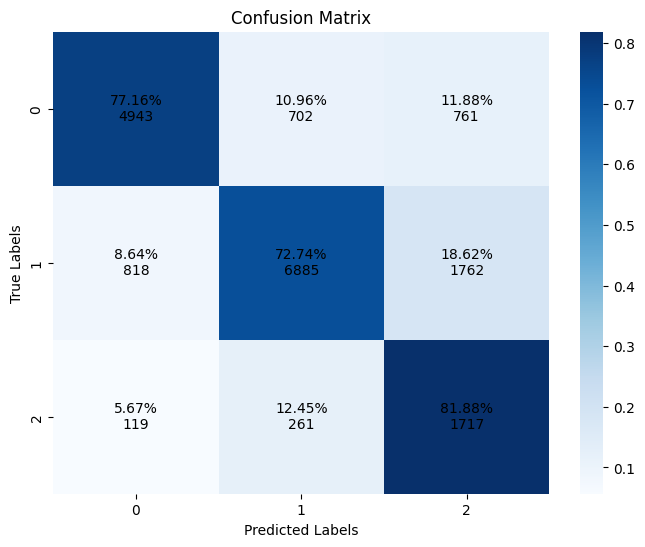

In [94]:
eval_model(CNN_10feature_model,CNN_100_10_path,hrv_10_100_val_dataloader) 

#### LSTM

In [95]:
hrv_10_100_reshape_train_dataloader = pre_data_loader(hrv_10_100_X_train, hrv_10_100_Y_train,32,Reshape=True,feature_nums=10,Seq_len=101)
hrv_10_100_reshape_val_dataloader = pre_data_loader(hrv_10_100_X_val,hrv_10_100_Y_val,32,Reshape=True,feature_nums=10,Seq_len=101)
hrv_10_100_reshape_test_dataloader = pre_data_loader(hrv_10_100_X_test,hrv_10_100_Y_test,32,Reshape=True,feature_nums=10,Seq_len=101)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [96]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM 隐藏单元数量
num_layers = 2 # LSTM 层数
num_classes = 3  # 分类类别数量

# 创建 LSTM 模型
LSTM_model_10_mh_pnni50 = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_model_10_mh_pnni50.parameters(), lr=0.0001, alpha=0.9)
# 打印模型结构
print(LSTM_model_10_mh_pnni50)

LSTMClassifier(
  (lstm): LSTM(101, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)


In [97]:
LSTM_meanhr_pnni50_100_path = './models/DL_LSTM_100_meanhr_pnni50_model.pth'
train_save(40,LSTM_model_10_mh_pnni50,LSTM_meanhr_pnni50_100_path,hrv_10_100_reshape_train_dataloader,hrv_10_100_reshape_val_dataloader)

Epoch [1/40] - Train Loss: 0.4778, Val Loss: 0.4559
Epoch [2/40] - Train Loss: 0.4401, Val Loss: 0.4376
Epoch [3/40] - Train Loss: 0.4175, Val Loss: 0.4221
Epoch [4/40] - Train Loss: 0.3942, Val Loss: 0.4056
Epoch [5/40] - Train Loss: 0.3649, Val Loss: 0.3863
Epoch [6/40] - Train Loss: 0.3268, Val Loss: 0.3630
Epoch [7/40] - Train Loss: 0.2785, Val Loss: 0.3373
Epoch [8/40] - Train Loss: 0.2249, Val Loss: 0.3139
Epoch [9/40] - Train Loss: 0.1730, Val Loss: 0.3033
Epoch [10/40] - Train Loss: 0.1273, Val Loss: 0.3073
Epoch [11/40] - Train Loss: 0.0926, Val Loss: 0.3176
Epoch [12/40] - Train Loss: 0.0675, Val Loss: 0.3343
Epoch [13/40] - Train Loss: 0.0514, Val Loss: 0.3565
Early stopping triggered. Training stopped.


Accuracy: 85.66%
Precision:: 0.8330
Recall: 0.8147
F1 Score: 0.8230
hrv feature 3 classification Confusion Matrix:
[[ 6932   909   185]
 [ 1076 10600   304]
 [  275   472  1707]]


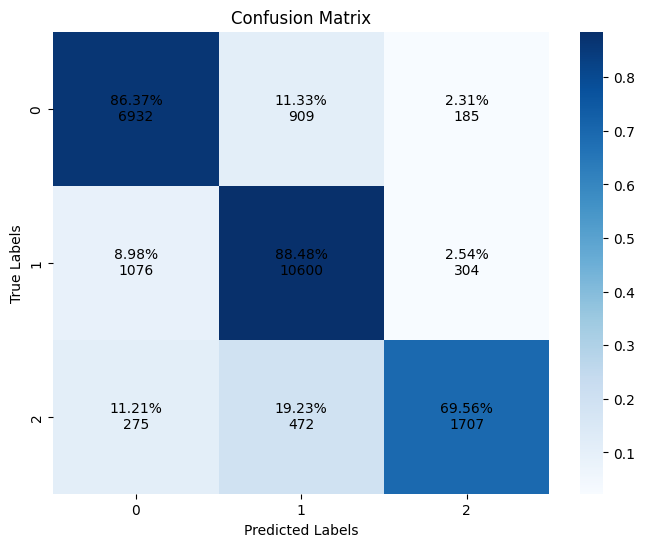

In [98]:
eval_model(LSTM_model_10_mh_pnni50,LSTM_meanhr_pnni50_100_path,hrv_10_100_reshape_test_dataloader) 

#### LSTM-Attention

In [100]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM隐藏单元数量
num_layers = 2  # LSTM层数
num_classes = 3  # 分类类别数量
num_heads = 8  # 自注意力机制中的注意力头数

# 创建模型
LSTM_Attentionnn_model_mh_pnni50 = TransformerLSTMClassifier(input_size, hidden_size, num_layers, num_classes, num_heads).to(device)
LSTM_Attentionnn_model_mh_pnni50.to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_Attentionnn_model_mh_pnni50.parameters(), lr=0.0002, alpha=0.9)

Epoch [1/40] - Train Loss: 0.4779, Val Loss: 0.4516
Epoch [2/40] - Train Loss: 0.4314, Val Loss: 0.4249
Epoch [3/40] - Train Loss: 0.3964, Val Loss: 0.3998
Epoch [4/40] - Train Loss: 0.3526, Val Loss: 0.3684
Epoch [5/40] - Train Loss: 0.2984, Val Loss: 0.3517
Epoch [6/40] - Train Loss: 0.2382, Val Loss: 0.3273
Epoch [7/40] - Train Loss: 0.1809, Val Loss: 0.3448
Epoch [8/40] - Train Loss: 0.1374, Val Loss: 0.3479
Epoch [9/40] - Train Loss: 0.1062, Val Loss: 0.3298
Epoch [10/40] - Train Loss: 0.0830, Val Loss: 0.3471
Early stopping triggered. Training stopped.
Accuracy: 85.88%
Precision:: 0.8471
Recall: 0.8071
F1 Score: 0.8237
hrv feature 3 classification Confusion Matrix:
[[ 7013   893   120]
 [ 1101 10661   218]
 [  321   519  1614]]


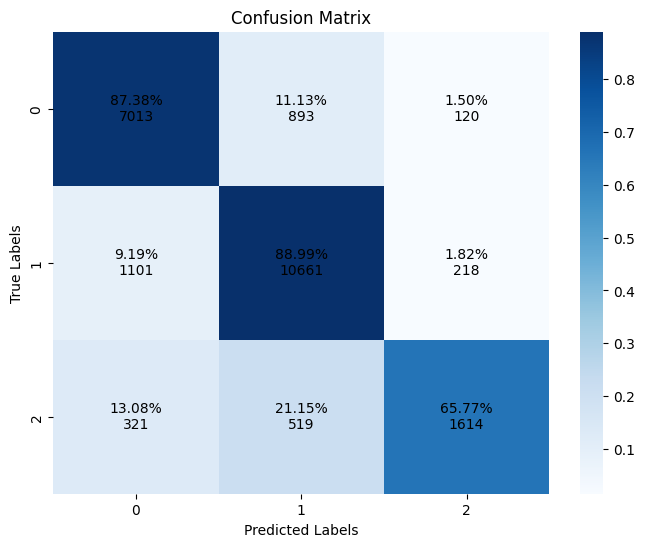

In [101]:
LSTM_Attention_10_model_path = './models/DL_LSTM_Attention_meanhr_pnni50_model.pth'
train_save(40,LSTM_Attentionnn_model_mh_pnni50,LSTM_Attention_10_model_path,hrv_10_100_reshape_train_dataloader,hrv_10_100_reshape_val_dataloader)
eval_model(LSTM_Attentionnn_model_mh_pnni50,LSTM_Attention_10_model_path,hrv_10_100_reshape_test_dataloader)